# Marketing Funnel by Olist
## About Dataset
### Marketing Funnel by Olist
Welcome! This is a marketing funnel dataset from sellers that filled-in requests of contact to sell their products on Olist Store. The dataset has information of 8k Marketing Qualified Leads (MQLs) that requested contact between Jun. 1st 2017 and Jun 1st 2018. They were randomly sampled from the total of MQLs.

Its features allows viewing a sales process from multiple dimensions: lead category, catalog size, behaviour profile, etc.

This is real data, it has been anonymized and sampled from the original dataset.

### Joining with Brazilian E-Commerce Public Dataset by Olis
This dataset can also be linked to the Brazilian E-Commerce Public Dataset by Olist using seller_id. There you will find information of 100k orders, price, payment, freight performance, customer location, product attributes and finally reviews written by customers.

### Context
This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

A seller join Olist through a marketing and sales funnel that was made public at this dataset. Description of steps:

1. Sign-up at a landing page.
2. Get contacted by a Sales development Representative (SDR), confirm some information and schedule a consultancy.
3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
4. Lead becomes a seller and starts building his catalog on Olist.
5. His products are published on marketplaces and ready to sell!

### Attention
A seller MQL might come from multiple sources (he might subscribe on two different landing pages, for instance).

### Examples of Landing Pages
![img1](https://i.imgur.com/jKZTP5e.png)
![img2](https://i.imgur.com/mAljYcq.png)

### Data Schema
The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

![img3](https://i.imgur.com/HRhd2Y0.png)

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import os
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go

In [215]:
for idx, file in enumerate(os.listdir('../data/marketing funnel by olist')):
    print(idx, '-', file)

0 - olist_closed_deals_dataset.csv
1 - olist_customers_dataset.csv
2 - olist_geolocation_dataset.csv
3 - olist_marketing_qualified_leads_dataset.csv
4 - olist_orders_dataset.csv
5 - olist_order_items_dataset.csv
6 - olist_order_payments_dataset.csv
7 - olist_order_reviews_dataset.csv
8 - olist_products_dataset.csv
9 - olist_sellers_dataset.csv
10 - product_category_name_translation.csv


## Load data

In [216]:
# leads dataset
customers = pd.read_csv("../data/marketing funnel by olist/olist_customers_dataset.csv")
order_items = pd.read_csv("../data/marketing funnel by olist/olist_order_items_dataset.csv")
order_payments = pd.read_csv("../data/marketing funnel by olist/olist_order_payments_dataset.csv")
orders = pd.read_csv("../data/marketing funnel by olist/olist_orders_dataset.csv")

In [217]:
# displaying data shape
dataset = {
    "Customers": customers,
    "Order Items": order_items,
    "Payments": order_payments,
    "Orders": orders
}

for x, y in dataset.items():
    print(f"{x}", y.shape)

Customers (99441, 5)
Order Items (112650, 7)
Payments (103886, 5)
Orders (99441, 8)


In [218]:
# displaying dataset column names
for x, y in dataset.items():
    print(f"{x}", f"{list(y.columns)}\n")

Customers ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Order Items ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Payments ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

Orders ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']



In [219]:
# checking for null values in dataset
for x, y in dataset.items():
    print(f"{x}: {y.isnull().any().any()}")

Customers: False
Order Items: False
Payments: False
Orders: True


In [220]:
# taking count for dataset with missing values
for x, y in dataset.items():
    if y.isnull().any().any():
        print(f"{x}", (list(y.shape)), "\n")
        print(f"{y.isnull().sum()}\n")

Orders [99441, 8] 

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64



In [221]:
# creating master dataframe
df1 = order_payments.merge(order_items, on="order_id")
df2 = df1.merge(orders, on="order_id")
df = df2.merge(customers, on="customer_id")

print(df.shape)

(117601, 22)


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117601 non-null  object 
 1   payment_sequential             117601 non-null  int64  
 2   payment_type                   117601 non-null  object 
 3   payment_installments           117601 non-null  int64  
 4   payment_value                  117601 non-null  float64
 5   order_item_id                  117601 non-null  int64  
 6   product_id                     117601 non-null  object 
 7   seller_id                      117601 non-null  object 
 8   shipping_limit_date            117601 non-null  object 
 9   price                          117601 non-null  float64
 10  freight_value                  117601 non-null  float64
 11  customer_id                    117601 non-null  object 
 12  order_status                  

In [223]:
# converting date columns to datetime
date_columns = ["order_purchase_timestamp",
                "order_delivered_carrier_date",
                "order_delivered_customer_date",
                "order_estimated_delivery_date",
                "shipping_limit_date",
                "order_approved_at"]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")

df[date_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
order_approved_at                datetime64[ns]
dtype: object

In [224]:
# cleaning up name columns
df["customer_city"] = df["customer_city"].str.title() # 문장 내 단어별 첫글자를 대문자로 변화
df["payment_type"] = df["payment_type"].str.replace("_", " ").str.title()

# enginnering new / essential columns
df["delivery_against_estimated"] = (df["order_estimated_delivery_date"] - df["order_delivered_customer_date"]).dt.days
df["order_purchase_year"] = df.order_purchase_timestamp.map(lambda x: x.year)
df["order_purchase_month"] = df.order_purchase_timestamp.map(lambda x: x.month)
df["order_purchase_dayofweek"] = df.order_purchase_timestamp.map(lambda x: x.dayofweek)
df["order_purchase_hour"] = df.order_purchase_timestamp.map(lambda x: x.hour)
df["order_purchase_day"] = df["order_purchase_dayofweek"].map({0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"})
df["order_purchase_mon"] = df.order_purchase_timestamp.map(lambda x: x.month).map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun",
                                                                                    7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

In [225]:
# chaning the month attribute for same format
df["month_year"] = df["order_purchase_month"].astype(str).map(lambda x: "0" + x if len(x) == 1 else x)
df["month_year"] = df["order_purchase_year"].astype(str) + "-" + df["month_year"].astype(str)

# creating year month column
df["month_y"] = df["order_purchase_timestamp"].map(lambda date: 100 * date.year + date.month)

In [226]:
# displaying summary statistics of columns
df.describe(include="all")

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
count,117601,117601.000000,117601,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000,117601.000000,117601,117601,117601,117586,116356,115034,117601,117601,117601.000000,117601,117601,115034.000000,117601.000000,117601.000000,117601.000000,117601.000000,117601,117601,117601,117601.000000
unique,98665,NaN,4,NaN,NaN,NaN,32951,3095,93317,NaN,NaN,98665,7,98111,90173,81016,95663,449,95419,NaN,4110,27,NaN,NaN,NaN,NaN,NaN,7,12,24,NaN
top,895ab968e7bb0d5659d16cd74cd1650c,NaN,Credit Card,NaN,NaN,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,270c23a11d024a44c896d1894b261a83,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,9a736b248f67d166d2fbb006bcb877c3,NaN,Sao Paulo,SP,NaN,NaN,NaN,NaN,NaN,Mon,Aug,2017-11,NaN
freq,63,NaN,86769,NaN,NaN,NaN,536,2133,63,NaN,NaN,63,115035,63,63,63,63,649,75,NaN,18590,49566,NaN,NaN,NaN,NaN,NaN,19130,12632,9016,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN,NaN,NaN,2016-09-04 21:15:19,2016-10-04 09:43:32,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.093528,NaN,2.939482,172.686752,1.195900,NaN,NaN,NaN,120.824783,20.045990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35051.793097,NaN,NaN,11.043326,2017.538193,6.028129,2.745750,14.760002,NaN,NaN,NaN,201759.847399
std,NaN,0.726692,NaN,2.774223,267.592290,0.697706,NaN,NaN,NaN,184.479323,15.861315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29820.588877,NaN,NaN,10.162307,0.505065,3.229579,1.961257,5.325670,NaN,NaN,NaN,48.798820
min,NaN,1.000000,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.850000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1003.000000,NaN,NaN,-189.000000,2016.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,201609.000000
25%,NaN,1.000000,NaN,1.000000,60.870000,1.000000,NaN,NaN,NaN,39.900000,13.080000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11310.000000,NaN,NaN,6.000000,2017.000000,3.000000,1.000000,11.000000,NaN,NaN,NaN,201709.000000


In [227]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending=False)
percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
pd.concat([missing_values, percentage], axis=1, keys=["Values", "Percentage"])

,Values,Percentage
order_delivered_customer_date,2567,2.182805
delivery_against_estimated,2567,2.182805
order_delivered_carrier_date,1245,1.058664
order_approved_at,15,0.012755
month_year,0,0.000000
order_purchase_mon,0,0.000000
order_purchase_day,0,0.000000
order_purchase_hour,0,0.000000
order_purchase_dayofweek,0,0.000000
order_purchase_month,0,0.000000


In [228]:
# dropping missing values
df = df.dropna()
df.isnull().values.any()

False

In [229]:
# displaying dateframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

In [230]:
# excluding incomplete 2012 data and displaying first 3 rows of master dataframe
df = df.query("month_year != '2016-12' and month_year != '2016-10'")
df.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_against_estimated,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,month_year,month_y
0,b81ef226f3fe1789b1e8b2acac839d17,1,Credit Card,8,99.33,1,af74cc53dcffc8384b29e7abfa41902b,213b25e6f54661939f11710a6fddb871,2018-05-02 22:15:09,79.80,19.53,0a8556ac6be836b46b3e89920d59291c,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22,708ab75d2a007f0564aedd11139c7708,39801,Teofilo Otoni,MG,12.0,2018,4,2,22,Wed,Apr,2018-04,201804
1,a9810da82917af2d9aefd1278f1dcfa0,1,Credit Card,1,24.39,1,a630cc320a8c872f9de830cf121661a3,eaf6d55068dea77334e8477d3878d89e,2018-07-02 11:18:58,17.00,7.39,f2c7fc58a9de810828715166c672f10a,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16,a8b9d3a27068454b1c98cc67d4e31e6f,2422,Sao Paulo,SP,16.0,2018,6,1,11,Tue,Jun,2018-06,201806
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,Credit Card,1,65.71,1,2028bf1b01cafb2d2b1901fca4083222,cc419e0650a3c5ba77189a1882b7556a,2017-12-26 09:52:34,56.99,8.72,25b14b69de0b6e184ae6fe2755e478f9,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04,6f70c0b2f7552832ba46eb57b1c5651e,2652,Sao Paulo,SP,16.0,2017,12,1,11,Tue,Dec,2017-12,201712


## Monthly Revenue

In [231]:
# Calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
monthly_rev = df.groupby(["month_year"])["payment_value"].sum().reset_index()
monthly_rev

,month_year,payment_value
0,2017-01,176376.56
1,2017-02,323815.95
2,2017-03,505735.83
3,2017-04,456108.32
4,2017-05,701119.60
5,2017-06,585400.98
6,2017-07,716069.98
7,2017-08,842689.94
8,2017-09,996085.61
9,2017-10,998609.62


## Monthly Revenue Growth Rate

In [232]:
# Calculate for monthly revenue growth rate
# Using pct_change() function to see monthly percentage change
monthly_rev["Monthly_Growth"] = monthly_rev["payment_value"].pct_change()
monthly_rev

,month_year,payment_value,Monthly_Growth
0,2017-01,176376.56,NaN
1,2017-02,323815.95,0.835935
2,2017-03,505735.83,0.561800
3,2017-04,456108.32,-0.098129
4,2017-05,701119.60,0.537178
5,2017-06,585400.98,-0.165048
6,2017-07,716069.98,0.223213
7,2017-08,842689.94,0.176826
8,2017-09,996085.61,0.182031
9,2017-10,998609.62,0.002534


## Monthly Active Customers

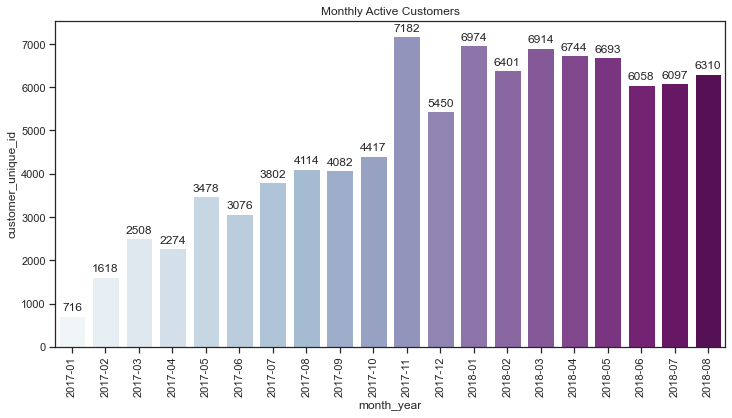

In [233]:
# Creating monthly active customers dataframe by counting unique Customer ID
monthly_active_cust = df.groupby(["month_year"])["customer_unique_id"].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="customer_unique_id", data=monthly_active_cust, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Monthly Active Customers")
plt.show()

## Monthly Order Count

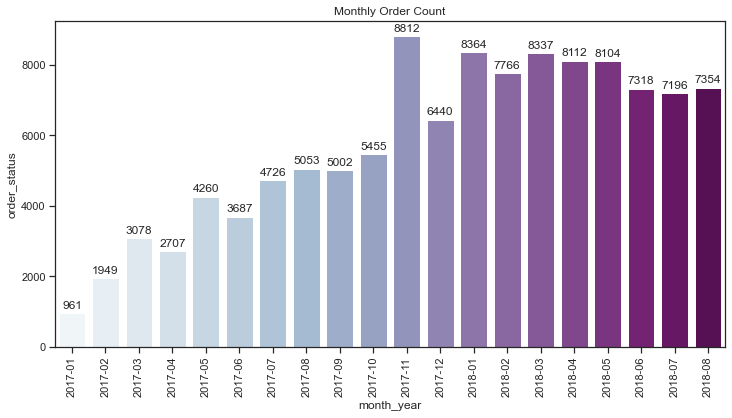

In [234]:
# Creating monthly active customers dataframe by counting order status
monthly_sales_volume = df.groupby(["month_year"])["order_status"].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="order_status", data=monthly_sales_volume, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Monthly Order Count")
plt.show()

## Average Revenue per Customer Purchase

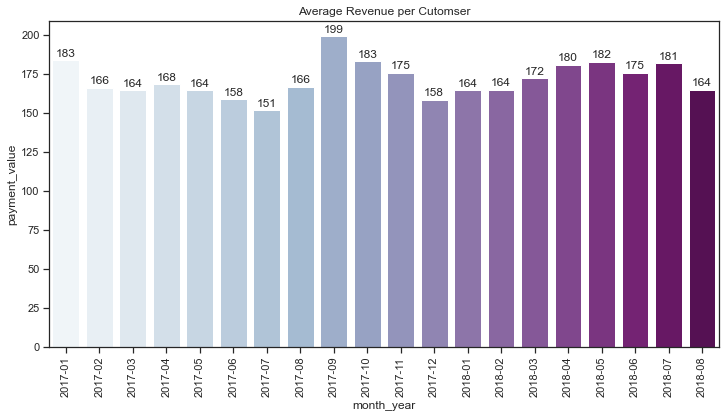

In [235]:
# Creating a new dataframe for average revenue
monthly_avg_rev = df.groupby(["month_year"])["payment_value"].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="payment_value", data=monthly_avg_rev, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.set_title("Average Revenue per Cutomser")
ax.bar_label(ax.containers[0], padding=2, fmt="%i")
plt.show()

## New Customer Ratio

In [236]:
# Create a dataframe containing Customer ID and first purchase date
min_purchase = df.groupby(["customer_unique_id"])["order_purchase_timestamp"].min().reset_index()
min_purchase.columns = ["customer_unique_id", "min_purchase_date"]
min_purchase["min_purchase_date"] = min_purchase["min_purchase_date"].map(lambda date: date.strftime("%Y%m"))
min_purchase["min_purchase_date"] = min_purchase["min_purchase_date"].astype(int)
                                                                          
# Merge first purchase date column to the main dataframe
df = pd.merge(df, min_purchase, on="customer_unique_id")

In [237]:
# Create a column called Customer Type and assign Existing
# If Customer"s First Purchase Year Month before the selected Invoice Year Month
df["customer_type"] = "New"
df.loc[df["month_y"] > df["min_purchase_date"], "customer_type"] = "Existing"

In [238]:
# Calculate the Revenue per month for each user type
customer_type_revenue = df.groupby(["month_y", "customer_type", "month_year"])["payment_value"].sum().reset_index()
customer_type_revenue

,month_y,customer_type,month_year,payment_value
0,201701,New,2017-01,176376.56
1,201702,Existing,2017-02,111.07
2,201702,New,2017-02,323704.88
3,201703,Existing,2017-03,596.38
4,201703,New,2017-03,505139.45
5,201704,Existing,2017-04,2677.76
6,201704,New,2017-04,453430.56
7,201705,Existing,2017-05,6733.95
8,201705,New,2017-05,694385.65
9,201706,Existing,2017-06,6956.06


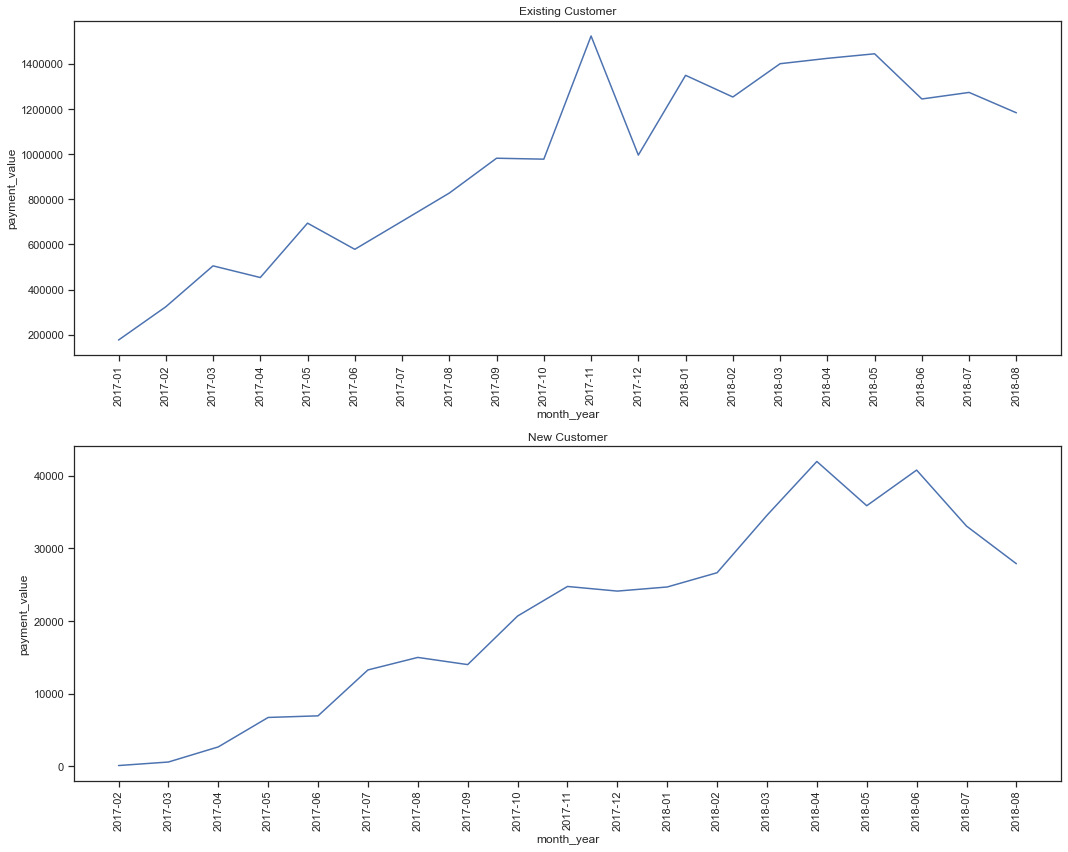

In [239]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=False)

sns.lineplot(x="month_year", y="payment_value", data=customer_type_revenue.query("customer_type == 'New'"), ax=ax[0])
sns.lineplot(x="month_year", y="payment_value", data=customer_type_revenue.query("customer_type == 'Existing'"), ax=ax[1])

ax[0].tick_params(axis="x", labelrotation=90)
ax[1].tick_params(axis="x", labelrotation=90)

ax[0].set_title("Existing Customer")
ax[1].set_title("New Customer")

ax[0].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [240]:
# Create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
df_user_ratio = df.query("customer_type == 'New'").groupby(["month_year"])["customer_unique_id"].nunique() / df.query("customer_type == 'Existing'").groupby(["month_year"])["customer_unique_id"].nunique()
df_user_ratio = df_user_ratio.reset_index()

# drop nan valaues that resulted from first month
df_user_ratio = df_user_ratio.dropna()
df_user_ratio.columns = ["month_year", "NewCustRatio"]
df_user_ratio

,month_year,NewCustRatio
1,2017-02,808.000000
2,2017-03,500.600000
3,2017-04,132.764706
4,2017-05,123.214286
5,2017-06,77.871795
6,2017-07,76.591837
7,2017-08,71.175439
8,2017-09,51.333333
9,2017-10,49.193182
10,2017-11,57.868852


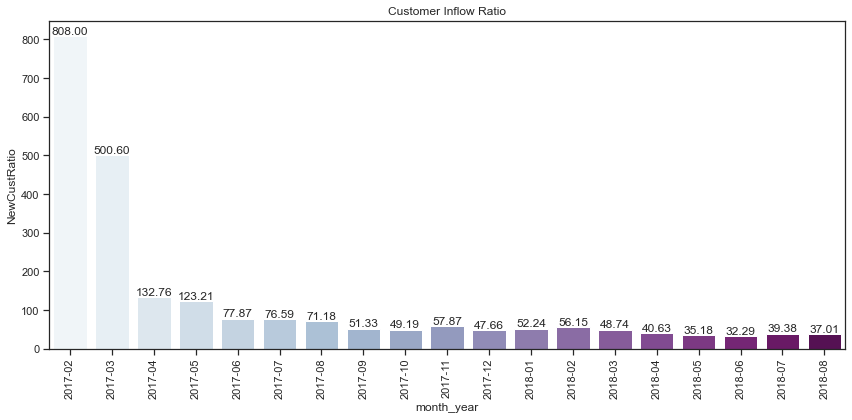

In [241]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month_year", y="NewCustRatio", data=df_user_ratio, palette="BuPu")
ax.tick_params(axis="x", labelrotation=90)
ax.set_title("Customer Inflow Ratio")
ax.bar_label(ax.containers[0], padding=0, fmt="%.2f")
plt.tight_layout()
plt.show()

## Monthly Retention Rate

In [242]:
# Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total (using crosstab)
# Identifying active users are active by looking at their revenue per month
df_user_purchase = df.groupby(["customer_unique_id", "month_y"])["payment_value"].sum().reset_index()
df_user_purchase.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,27.19
2,0000f46a3911fa3c0805444483337064,201703,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,201710,43.62
4,0004aac84e0df4da2b147fca70cf8255,201711,196.89


In [243]:
# Identifying active users are active by looking at their order count per month
df_active_user = df.groupby(["customer_unique_id", "month_y"])["payment_value"].count().reset_index()
df_active_user.head()

,customer_unique_id,month_y,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,201805,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,201805,1
2,0000f46a3911fa3c0805444483337064,201703,1
3,0000f6ccb0745a6a4b88665a16c9f078,201710,1
4,0004aac84e0df4da2b147fca70cf8255,201711,1


In [244]:
# Create retention matrix with crosstab using purchase
df_retention = pd.crosstab(df_active_user["customer_unique_id"], df_user_purchase["month_y"]).reset_index()
df_retention.head()

month_y,customer_unique_id,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [245]:
# Creating an array of dictionary which keeps Retained & Total User count for each month
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data["month_y"] = int(selected_month)
    retention_data["TotalUserCount"] = df_retention[selected_month].sum()
    retention_data["RetainedUserCount"] = df_retention.loc[(df_retention[selected_month] > 0) & (df_retention[prev_month] > 0), selected_month].sum()
    retention_array.append(retention_data)

# Convert the array to dataframe and calculate Retention Rate
df_retention = pd.DataFrame(retention_array)
df_retention["RetentionRate"] = df_retention["RetainedUserCount"] / df_retention["TotalUserCount"]

df_retention

,month_y,TotalUserCount,RetainedUserCount,RetentionRate
0,201703,2508,3,0.001196
1,201704,2274,11,0.004837
2,201705,3478,14,0.004025
3,201706,3076,16,0.005202
4,201707,3802,16,0.004208
5,201708,4114,23,0.005591
6,201709,4082,32,0.007839
7,201710,4417,32,0.007245
8,201711,7182,37,0.005152
9,201712,5450,41,0.007523


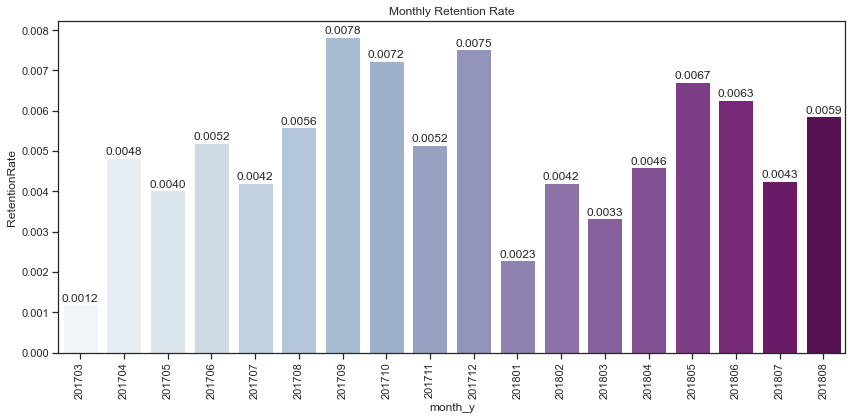

In [246]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='month_y', y='RetentionRate', data=df_retention, palette="BuPu", orient="v")
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Monthly Retention Rate")
ax.bar_label(ax.containers[0], padding=1, fmt="%.4f")
plt.tight_layout()
plt.style.use("seaborn-whitegrid")
plt.show()

## Cohort Based First Purchase Month

Cohorts are determined as first purchase year-month of the customers. I will be measuring what percentage of the customers retained after their first purchase in each month. This view will help unveil how recent and old cohorts differ regarding retention rate and if recent changes in customer experience affected new customer’s retention or not.

In [293]:
# first_order
df_cohort = df[["customer_unique_id", "payment_value", "order_id", "month_y"]]
df_cohort["month_y"] = pd.to_datetime(df_cohort["month_y"], format="%Y%m")
df_cohort["month_y"] = df_cohort["month_y"].dt.strftime("%Y-%m")

In [251]:
first_order = df_cohort.groupby(["customer_unique_id"])["month_y"].min()
first_order

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2018-05
0000b849f77a49e4a4ce2b2a4ca5be3f    2018-05
0000f46a3911fa3c0805444483337064    2017-03
0000f6ccb0745a6a4b88665a16c9f078    2017-10
0004aac84e0df4da2b147fca70cf8255    2017-11
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    2017-06
fffea47cd6d3cc0a88bd621562a9d061    2017-12
ffff371b4d645b6ecea244b27531430a    2017-02
ffff5962728ec6157033ef9805bacc48    2018-05
ffffd2657e2aad2907e67c3e9daecbeb    2017-05
Name: month_y, Length: 93083, dtype: object

In [252]:
df_cohort.set_index("customer_unique_id", inplace=True)
df_cohort["first_order"] = first_order
df_cohort

,payment_value,order_id,month_y,first_order
customer_unique_id,,,,
708ab75d2a007f0564aedd11139c7708,99.33,b81ef226f3fe1789b1e8b2acac839d17,2018-04,2018-04
a8b9d3a27068454b1c98cc67d4e31e6f,24.39,a9810da82917af2d9aefd1278f1dcfa0,2018-06,2018-06
6f70c0b2f7552832ba46eb57b1c5651e,65.71,25e8ea4e93396b6fa0d3dd708e76c1bd,2017-12,2017-12
87695ed086ebd36f20404c82d20fca87,107.78,ba78997921bbcdc1373bb41e913ab953,2017-12,2017-12
4291db0da71914754618cd789aebcd56,128.45,42fdf880ba16b47b59251dd489d4441a,2018-05,2018-05
...,...,...,...,...
18f40b803060d9883643b7e64e91628e,194.11,3531718b24dfd5022fb0d101e10e33b9,2018-03,2018-03
13f283df2f4760f22b57830865761d07,198.94,c45067032fd84f4cf408730ff5205568,2018-05,2018-05
b6027ac07fb76ebca8c97b1887865aee,363.31,0406037ad97740d563a178ecc7a2075c,2018-03,2018-03


In [253]:
df_cohort.reset_index(inplace=True)
df_cohort

,customer_unique_id,payment_value,order_id,month_y,first_order
0,708ab75d2a007f0564aedd11139c7708,99.33,b81ef226f3fe1789b1e8b2acac839d17,2018-04,2018-04
1,a8b9d3a27068454b1c98cc67d4e31e6f,24.39,a9810da82917af2d9aefd1278f1dcfa0,2018-06,2018-06
2,6f70c0b2f7552832ba46eb57b1c5651e,65.71,25e8ea4e93396b6fa0d3dd708e76c1bd,2017-12,2017-12
3,87695ed086ebd36f20404c82d20fca87,107.78,ba78997921bbcdc1373bb41e913ab953,2017-12,2017-12
4,4291db0da71914754618cd789aebcd56,128.45,42fdf880ba16b47b59251dd489d4441a,2018-05,2018-05
...,...,...,...,...,...
114676,18f40b803060d9883643b7e64e91628e,194.11,3531718b24dfd5022fb0d101e10e33b9,2018-03,2018-03
114677,13f283df2f4760f22b57830865761d07,198.94,c45067032fd84f4cf408730ff5205568,2018-05,2018-05
114678,b6027ac07fb76ebca8c97b1887865aee,363.31,0406037ad97740d563a178ecc7a2075c,2018-03,2018-03
114679,b84dc68f02f122a88d7e7bbd37b06204,369.54,b8b61059626efa996a60be9bb9320e10,2018-08,2018-08


In [254]:
# Aggregation cohort groups and order_period data
grouped = df_cohort.groupby(["first_order", "month_y"])
cohorts = grouped["customer_unique_id"].nunique()
cohorts

first_order  month_y
2017-01      2017-01     716
             2017-02       2
             2017-03       2
             2017-04       1
             2017-05       3
                        ... 
2018-06      2018-07      25
             2018-08      16
2018-07      2018-07    5946
             2018-08      31
2018-08      2018-08    6144
Name: customer_unique_id, Length: 207, dtype: int64

In [255]:
cohorts = cohorts.reset_index()
cohorts

,first_order,month_y,customer_unique_id
0,2017-01,2017-01,716
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
202,2018-06,2018-07,25
203,2018-06,2018-08,16
204,2018-07,2018-07,5946
205,2018-07,2018-08,31


In [256]:
cohorts = cohorts.rename(columns={"customer_unique_id": "total_customers"})
cohorts

,first_order,month_y,total_customers
0,2017-01,2017-01,716
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
202,2018-06,2018-07,25
203,2018-06,2018-08,16
204,2018-07,2018-07,5946
205,2018-07,2018-08,31


In [257]:
# Check missing period and data preprocessing
cohorts["first_order"].value_counts().sort_index()

2017-01    18
2017-02    18
2017-03    18
2017-04    17
2017-05    16
2017-06    15
2017-07    14
2017-08    13
2017-09    12
2017-10    11
2017-11    10
2017-12     9
2018-01     8
2018-02     7
2018-03     6
2018-04     5
2018-05     4
2018-06     3
2018-07     2
2018-08     1
Name: first_order, dtype: int64

In [258]:
cohorts[cohorts["first_order"] == "2017-01"]

,first_order,month_y,total_customers
0,2017-01,2017-01,716
1,2017-01,2017-02,2
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
5,2017-01,2017-06,1
6,2017-01,2017-07,3
7,2017-01,2017-08,1
8,2017-01,2017-09,1
9,2017-01,2017-11,3


In [259]:
cohorts.loc[cohorts.shape[0], "first_order"] = "2017-01"
cohorts.loc[cohorts.shape[0]-1, "month_y"] = "2017-10"
cohorts.loc[cohorts.shape[0]-1, "total_customers"] = 0
cohorts.sort_values(["first_order", "month_y"], inplace=True)

In [260]:
cohorts.loc[cohorts.shape[0], "first_order"] = "2017-01"
cohorts.loc[cohorts.shape[0]-1, "month_y"] = "2018-07"
cohorts.loc[cohorts.shape[0]-1, "total_customers"] = 0
cohorts.sort_values(["first_order", "month_y"], inplace=True)

In [261]:
cohorts[cohorts["first_order"] == "2017-02"]

,first_order,month_y,total_customers
18,2017-02,2017-02,1616.0
19,2017-02,2017-03,3.0
20,2017-02,2017-04,5.0
21,2017-02,2017-05,2.0
22,2017-02,2017-06,7.0
23,2017-02,2017-07,2.0
24,2017-02,2017-08,4.0
25,2017-02,2017-09,3.0
26,2017-02,2017-10,1.0
27,2017-02,2017-11,3.0


In [262]:
cohorts.loc[cohorts.shape[0], "first_order"] = "2017-02"
cohorts.loc[cohorts.shape[0]-1, "month_y"] = "2018-08"
cohorts.loc[cohorts.shape[0]-1, "total_customers"] = 0
cohorts.sort_values(["first_order", "month_y"], inplace=True)

In [263]:
each_period = cohorts["first_order"].value_counts().sort_index()
each_period

2017-01    20
2017-02    19
2017-03    18
2017-04    17
2017-05    16
2017-06    15
2017-07    14
2017-08    13
2017-09    12
2017-10    11
2017-11    10
2017-12     9
2018-01     8
2018-02     7
2018-03     6
2018-04     5
2018-05     4
2018-06     3
2018-07     2
2018-08     1
Name: first_order, dtype: int64

In [264]:
# Cohort period labeling
cohort_period = []

for x in each_period:
    for y in range(x):
        cohort_period.append(y)

In [265]:
cohorts["cohort_period"] = cohort_period
cohorts

,first_order,month_y,total_customers,cohort_period
0,2017-01,2017-01,716.0,0
1,2017-01,2017-02,2.0,1
2,2017-01,2017-03,2.0,2
3,2017-01,2017-04,1.0,3
4,2017-01,2017-05,3.0,4
...,...,...,...,...
202,2018-06,2018-07,25.0,1
203,2018-06,2018-08,16.0,2
204,2018-07,2018-07,5946.0,0
205,2018-07,2018-08,31.0,1


In [266]:
cohorts.set_index(["first_order", "cohort_period"], inplace=True)
cohorts

month_y  total_customers
first_order cohort_period                          
2017-01     0              2017-01            716.0
            1              2017-02              2.0
            2              2017-03              2.0
            3              2017-04              1.0
            4              2017-05              3.0
...                            ...              ...
2018-06     1              2018-07             25.0
            2              2018-08             16.0
2018-07     0              2018-07           5946.0
            1              2018-08             31.0
2018-08     0              2018-08           6144.0

[210 rows x 2 columns]

In [268]:
cohorts = cohorts["total_customers"].unstack(1)
cohorts

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_order,,,,,,,,,,,,,,,,,,,,
2017-01,716.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,0.0,1.0
2017-02,1616.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0,0.0,NaN
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0,NaN,NaN
2017-04,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3450.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,NaN,NaN,NaN,NaN,NaN
2017-07,3753.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4057.0,28.0,14.0,11.0,14.0,21.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4004.0,28.0,22.0,11.0,18.0,9.0,9.0,10.0,11.0,8.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
# Cohort retention calculation
customer_retention = cohorts.divide(cohorts[0], axis=0).round(4)
customer_retention

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
first_order,,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.0028,0.0028,0.0014,0.0042,0.0014,0.0042,0.0014,0.0014,0.0000,0.0042,0.0014,0.0070,0.0042,0.0014,0.0014,0.0028,0.0042,0.0,0.0014
2017-02,1.0,0.0019,0.0031,0.0012,0.0043,0.0012,0.0025,0.0019,0.0006,0.0019,0.0012,0.0031,0.0012,0.0019,0.0012,0.0006,0.0006,0.0019,0.0,NaN
2017-03,1.0,0.0044,0.0036,0.0040,0.0036,0.0016,0.0016,0.0032,0.0032,0.0008,0.0036,0.0012,0.0020,0.0012,0.0016,0.0024,0.0008,0.0012,NaN,NaN
2017-04,1.0,0.0062,0.0022,0.0018,0.0027,0.0027,0.0035,0.0031,0.0031,0.0018,0.0027,0.0009,0.0004,0.0004,0.0009,0.0009,0.0013,NaN,NaN,NaN
2017-05,1.0,0.0046,0.0046,0.0029,0.0029,0.0032,0.0041,0.0014,0.0026,0.0026,0.0026,0.0035,0.0023,0.0003,0.0017,0.0020,NaN,NaN,NaN,NaN
2017-06,1.0,0.0049,0.0040,0.0043,0.0030,0.0040,0.0036,0.0023,0.0013,0.0020,0.0030,0.0036,0.0016,0.0016,0.0023,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.0053,0.0035,0.0024,0.0029,0.0021,0.0032,0.0011,0.0019,0.0027,0.0021,0.0029,0.0013,0.0024,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.0069,0.0035,0.0027,0.0035,0.0052,0.0030,0.0027,0.0015,0.0015,0.0025,0.0020,0.0012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.0070,0.0055,0.0027,0.0045,0.0022,0.0022,0.0025,0.0027,0.0020,0.0025,0.0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


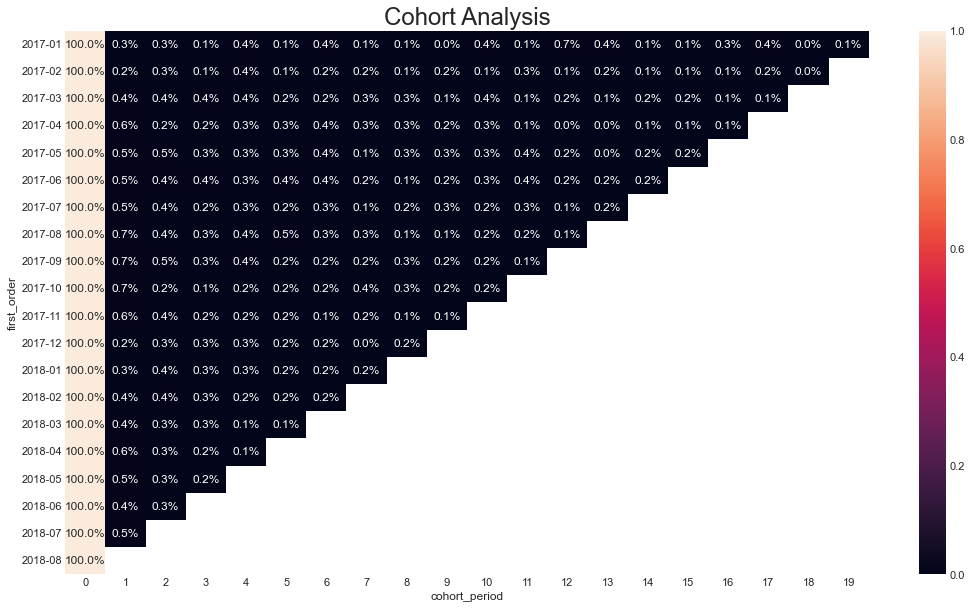

In [285]:
# Cohort result visualization
plt.figure(figsize=(18, 10))
plt.title("Cohort Analysis", fontsize=24)
sns.heatmap(customer_retention, annot=True, fmt=".1%")
plt.show()

In [316]:
df_cohort = df[["customer_unique_id", "payment_value", "order_id", "month_y"]]
df_cohort["month_y"] = pd.to_datetime(df_cohort["month_y"], format="%Y%m")
df_cohort["month_y"] = df_cohort["month_y"].dt.strftime("%Y-%m")

In [317]:
df_cohort.set_index("customer_unique_id", inplace=True)

In [318]:
df_cohort

,payment_value,order_id,month_y
customer_unique_id,,,
708ab75d2a007f0564aedd11139c7708,99.33,b81ef226f3fe1789b1e8b2acac839d17,2018-04
a8b9d3a27068454b1c98cc67d4e31e6f,24.39,a9810da82917af2d9aefd1278f1dcfa0,2018-06
6f70c0b2f7552832ba46eb57b1c5651e,65.71,25e8ea4e93396b6fa0d3dd708e76c1bd,2017-12
87695ed086ebd36f20404c82d20fca87,107.78,ba78997921bbcdc1373bb41e913ab953,2017-12
4291db0da71914754618cd789aebcd56,128.45,42fdf880ba16b47b59251dd489d4441a,2018-05
...,...,...,...
18f40b803060d9883643b7e64e91628e,194.11,3531718b24dfd5022fb0d101e10e33b9,2018-03
13f283df2f4760f22b57830865761d07,198.94,c45067032fd84f4cf408730ff5205568,2018-05
b6027ac07fb76ebca8c97b1887865aee,363.31,0406037ad97740d563a178ecc7a2075c,2018-03


In [319]:
df_cohort["cohort_group"] = df_cohort.groupby(level=0)["month_y"].min()
df_cohort.reset_index(inplace=True)
df_cohort

,customer_unique_id,payment_value,order_id,month_y,cohort_group
0,708ab75d2a007f0564aedd11139c7708,99.33,b81ef226f3fe1789b1e8b2acac839d17,2018-04,2018-04
1,a8b9d3a27068454b1c98cc67d4e31e6f,24.39,a9810da82917af2d9aefd1278f1dcfa0,2018-06,2018-06
2,6f70c0b2f7552832ba46eb57b1c5651e,65.71,25e8ea4e93396b6fa0d3dd708e76c1bd,2017-12,2017-12
3,87695ed086ebd36f20404c82d20fca87,107.78,ba78997921bbcdc1373bb41e913ab953,2017-12,2017-12
4,4291db0da71914754618cd789aebcd56,128.45,42fdf880ba16b47b59251dd489d4441a,2018-05,2018-05
...,...,...,...,...,...
114676,18f40b803060d9883643b7e64e91628e,194.11,3531718b24dfd5022fb0d101e10e33b9,2018-03,2018-03
114677,13f283df2f4760f22b57830865761d07,198.94,c45067032fd84f4cf408730ff5205568,2018-05,2018-05
114678,b6027ac07fb76ebca8c97b1887865aee,363.31,0406037ad97740d563a178ecc7a2075c,2018-03,2018-03
114679,b84dc68f02f122a88d7e7bbd37b06204,369.54,b8b61059626efa996a60be9bb9320e10,2018-08,2018-08


In [320]:
df_cohort.query("month_y != cohort_group")

,customer_unique_id,payment_value,order_id,month_y,cohort_group
5,4291db0da71914754618cd789aebcd56,99.29,f16cbac8a72057c2daba4b64662100ba,2018-08,2018-05
6,4291db0da71914754618cd789aebcd56,400.00,f16cbac8a72057c2daba4b64662100ba,2018-08,2018-05
41,d132b863416f85f2abb1a988ca05dd12,541.00,d0a945f85ba1074b60aac97ade7e240e,2018-04,2017-08
42,d132b863416f85f2abb1a988ca05dd12,541.00,d0a945f85ba1074b60aac97ade7e240e,2018-04,2017-08
43,d132b863416f85f2abb1a988ca05dd12,239.34,2296fa4ebace1edacb9f91509766eb18,2018-07,2017-08
...,...,...,...,...,...
112126,f497801658db70e1b18c76268001e944,99.25,a53622dd658d57199cd7a1e677564385,2017-12,2017-08
112170,941590fb8aef66b3a8352fe7c691879e,201.14,760312f5735ee281f01e56d5ddee05e3,2018-06,2018-01
112171,941590fb8aef66b3a8352fe7c691879e,201.14,760312f5735ee281f01e56d5ddee05e3,2018-06,2018-01
112917,e0a435b6106cae0bc42a2cef0565b622,54.62,f17562c57401466801e6a378f504a6d0,2017-10,2017-08
